In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import itertools
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.dummy import DummyClassifier
from textblob import TextBlob
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, learning_curve, ShuffleSplit

In [2]:
path = 'C:/Users/Вова/Desktop/smsspamcollection/SMSSpamCollection'
messages = pandas.read_csv(path, sep='\t',
                           names=["label", "message"])

In [3]:
print(messages.groupby('label').describe())

                                                        message
label                                                          
ham   count                                                4825
      unique                                               4516
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4


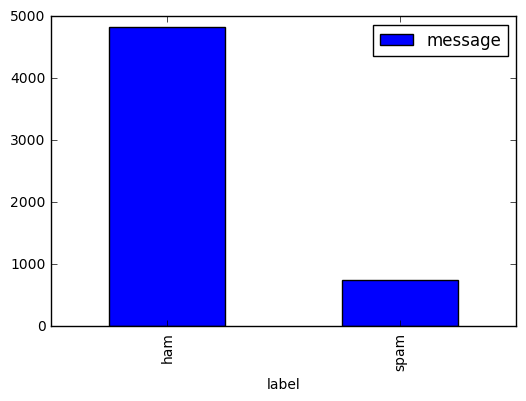

In [4]:
messages.groupby(['label']).count().plot(kind='bar')
plt.show()

In [65]:
#Очевидно, что выборка распределена очень плохо: сообщений класса ham почти в 6 раз больше, чем сообщений класса spam. 
#dummy classifier из-за несбалансированности будет очень плохо работать и всем присвваивать класс ham, скорее всего спам
#не будет выделяться

In [11]:
def tokenize(text):
    text = text.lower()
    return word_tokenize(text)

In [12]:
messages.message.head().apply(tokenize)

0    [go, until, jurong, point, ,, crazy.., availab...
1             [ok, lar, ..., joking, wif, u, oni, ...]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, ..., u, c, alrea...
4    [nah, i, do, n't, think, he, goes, to, usf, ,,...
Name: message, dtype: object

In [9]:
def tokenize_without_punct(message):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(message)

In [10]:
messages.message.head().apply(tokenize_without_punct)

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, don, t, think, he, goes, to, usf, he,...
Name: message, dtype: object

In [13]:
def split_into_lemmas(text):
    words = TextBlob(str(text)).words 
    return [word.lemma for word in words]

messages.message.head().apply(split_into_lemmas)

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, go, to, usf, he, ...
Name: message, dtype: object

In [14]:
ham = messages.loc[messages['label'] == 'ham'][:747]
spam = messages.loc[messages['label'] == 'spam']
data = ham.append(spam)
print(data.head())

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
6   ham  Even my brother is not like to speak with me. ...


In [15]:
bow = CountVectorizer(tokenizer=tokenize)
bowed_messages = bow.fit_transform(data['message'])
msg_train, msg_test, label_train, label_test = train_test_split(bowed_messages, data['label'], test_size=0.2)

In [16]:
naive_model = MultinomialNB()
naive_model.fit(msg_train, label_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [29]:
def split_into_lemmas(text):
    words = TextBlob(str(text)).words 
    return [word.lemma for word in words]

messages.message.head().apply(split_into_lemmas)

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, go, to, usf, he, ...
Name: message, dtype: object

In [21]:
bow = CountVectorizer(tokenizer=tokenize)
bowed_messages = bow.fit_transform(data['message'])
msg_train, msg_test, label_train, label_test = train_test_split(bowed_messages, data['label'], test_size=0.2)
print(msg_train.shape)

(1195, 4956)


In [22]:
naive_model = MultinomialNB()
naive_model.fit(msg_train, label_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [23]:
cv_results = cross_val_score(naive_model, bowed_messages, data['label'], cv=10, scoring='accuracy')
print(cv_results.mean(), cv_results.std())

0.956513513514 0.0111848252795


In [30]:
label_pred = naive_model.predict(msg_test)

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[142   3]
 [  7 147]]
Normalized confusion matrix
[[ 0.97931034  0.02068966]
 [ 0.04545455  0.95454545]]


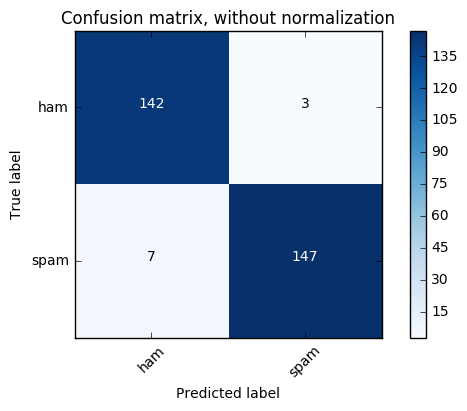

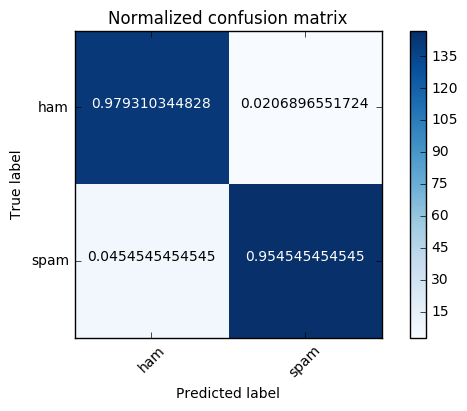

In [32]:
cnf_matrix = confusion_matrix(label_test, label_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=naive_model.classes_,
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=naive_model.classes_, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [33]:
print(classification_report(label_test, label_pred))

             precision    recall  f1-score   support

        ham       0.95      0.98      0.97       145
       spam       0.98      0.95      0.97       154

avg / total       0.97      0.97      0.97       299



In [ ]:
#Здесь был использован токенезатор, который считает знаки препинания как отдельный токен.
#Можно считать, что классификатор сработал достаточно хорошо. f1-score =0.97 - это считается хорошим результатом. В основном ошибки связаны с неправильным присвоением сообщения
#сообщениям классам spam класс ham

In [34]:
bow2 = CountVectorizer(tokenizer=tokenize_without_punct)
bowed_messages2 = bow2.fit_transform(data['message'])
msg_train2, msg_test2, label_train2, label_test2 = train_test_split(bowed_messages2, data['label'], test_size=0.2)

naive_model2 = MultinomialNB()
naive_model2.fit(msg_train2, label_train2)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [35]:
label_pred2 = naive_model2.predict(msg_test2)

Confusion matrix, without normalization
[[143   1]
 [  8 147]]
Normalized confusion matrix
[[ 0.99305556  0.00694444]
 [ 0.0516129   0.9483871 ]]


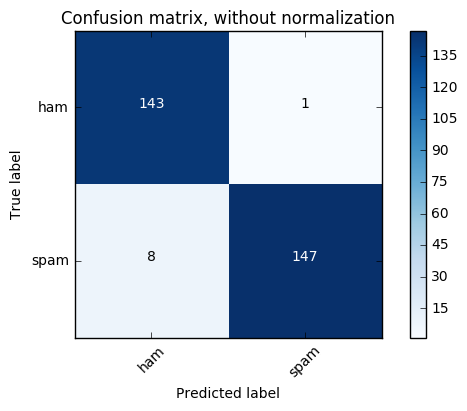

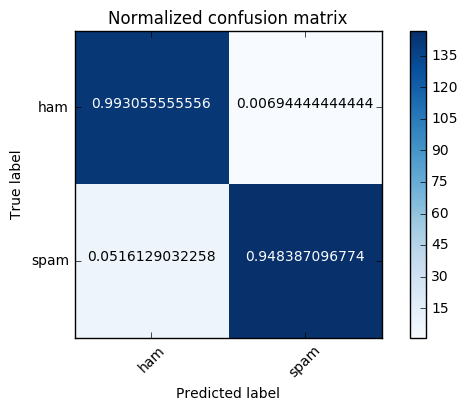

In [36]:
cnf_matrix2 = confusion_matrix(label_test2, label_pred2)
plt.figure()
plot_confusion_matrix(cnf_matrix2, classes=naive_model2.classes_,
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cnf_matrix2, classes=naive_model2.classes_, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [37]:
print(classification_report(label_test2, label_pred2))

             precision    recall  f1-score   support

        ham       0.95      0.99      0.97       144
       spam       0.99      0.95      0.97       155

avg / total       0.97      0.97      0.97       299



In [ ]:
#результаты, если использовать токенизатор, который не выделяет знаки препинания в отдельный токен. Результат почти такой же,
#однако ошибок распределения spam в ham стало на одну больше, а ошибок распределения ham в spam осталась только 1.

In [38]:
bow3 = CountVectorizer(analyzer=split_into_lemmas)
bowed_messages3 = bow3.fit_transform(data['message'])
msg_train3, msg_test3, label_train3, label_test3 = train_test_split(bowed_messages3, data['label'], test_size=0.2)

naive_model3 = MultinomialNB()
naive_model3.fit(msg_train3, label_train3)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [39]:
label_pred3 = naive_model3.predict(msg_test3)

Confusion matrix, without normalization
[[148   4]
 [  9 138]]
Normalized confusion matrix
[[ 0.97368421  0.02631579]
 [ 0.06122449  0.93877551]]


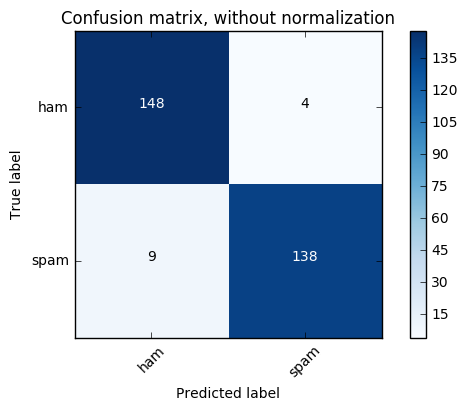

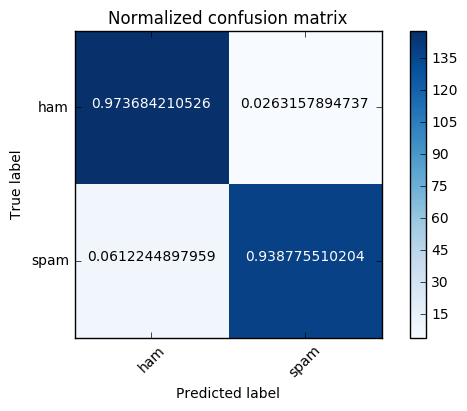

In [40]:
cnf_matrix3 = confusion_matrix(label_test3, label_pred3)
plt.figure()
plot_confusion_matrix(cnf_matrix3, classes=naive_model3.classes_,
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cnf_matrix3, classes=naive_model3.classes_, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [41]:
print(classification_report(label_test3, label_pred3))

             precision    recall  f1-score   support

        ham       0.94      0.97      0.96       152
       spam       0.97      0.94      0.96       147

avg / total       0.96      0.96      0.96       299



In [ ]:
#Результаты с лемматизацией. Видно, что классификатор сработал хуже, чем с двумя токенизаторами. Ошибок рапсределения spam в
#ham стало 9, а ошибочно распределенных ham в spam стало 4. Пока что это самый плохой результат

In [44]:
bow4 = CountVectorizer(analyzer=split_into_lemmas, stop_words='english')
bowed_messages4 = bow4.fit_transform(data['message'])
msg_train4, msg_test4, label_train4, label_test4 = train_test_split(bowed_messages4, data['label'], test_size=0.2)

naive_model4 = MultinomialNB()
naive_model4.fit(msg_train4, label_train4)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [45]:
label_pred4 = naive_model4.predict(msg_test4)

Confusion matrix, without normalization
[[130   3]
 [ 12 154]]
Normalized confusion matrix
[[ 0.97744361  0.02255639]
 [ 0.07228916  0.92771084]]


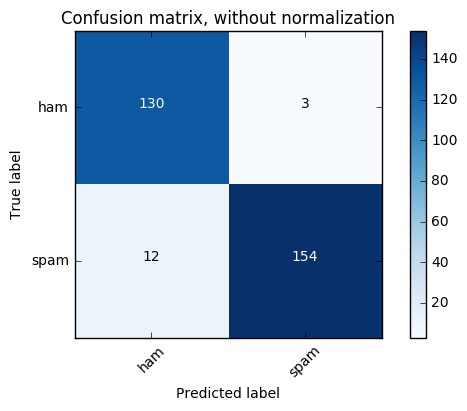

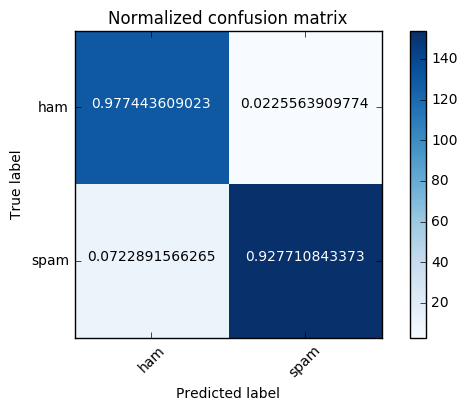

In [46]:
cnf_matrix4 = confusion_matrix(label_test4, label_pred4)
plt.figure()
plot_confusion_matrix(cnf_matrix4, classes=naive_model4.classes_,
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cnf_matrix4, classes=naive_model4.classes_, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [47]:
print(classification_report(label_test4, label_pred4))

             precision    recall  f1-score   support

        ham       0.92      0.98      0.95       133
       spam       0.98      0.93      0.95       166

avg / total       0.95      0.95      0.95       299



In [ ]:
#Результаты, если удалять стоп-слова, стали еще хуже. Ошибок рапсределения spam в
#ham стало 12, а ошибочно распределенных ham в spam стало 3.

In [49]:
bow5 = CountVectorizer(tokenizer=tokenize, min_df=0.15, max_df=0.85)
bowed_messages5 = bow5.fit_transform(data['message'])
msg_train5, msg_test5, label_train5, label_test5 = train_test_split(bowed_messages5, data['label'], test_size=0.2)

naive_model5 = MultinomialNB()
naive_model5.fit(msg_train5, label_train5)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [50]:
label_pred5 = naive_model5.predict(msg_test5)

Confusion matrix, without normalization
[[104  49]
 [ 18 128]]
Normalized confusion matrix
[[ 0.67973856  0.32026144]
 [ 0.12328767  0.87671233]]


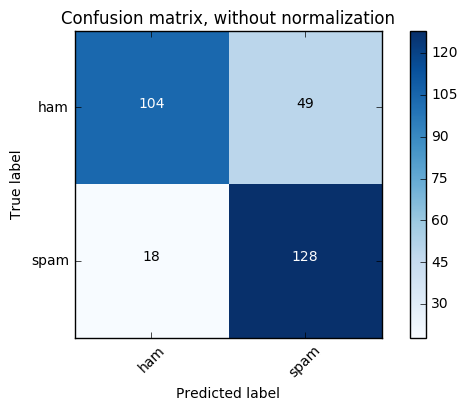

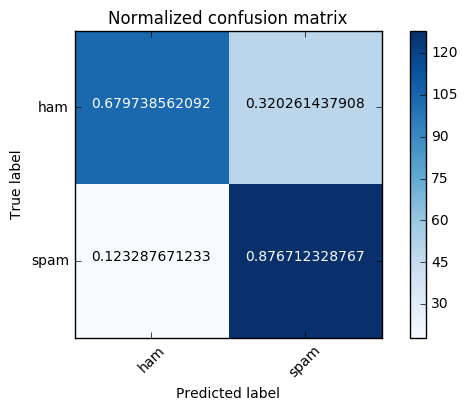

In [51]:
cnf_matrix5 = confusion_matrix(label_test5, label_pred5)
plt.figure()
plot_confusion_matrix(cnf_matrix5, classes=naive_model5.classes_,
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cnf_matrix5, classes=naive_model5.classes_, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
#пороги минимальной и максимальной document frequency показали самые плохие результаты

In [53]:
bow6 = TfidfVectorizer(tokenizer=tokenize_without_punct)
bowed_messages6 = bow6.fit_transform(data['message'])
msg_train6, msg_test6, label_train6, label_test6 = train_test_split(bowed_messages6, data['label'], test_size=0.2)

naive_model6 = MultinomialNB()
naive_model6.fit(msg_train6, label_train6)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [54]:
label_pred6 = naive_model6.predict(msg_test6)

Confusion matrix, without normalization
[[145   3]
 [  8 143]]
Normalized confusion matrix
[[ 0.97972973  0.02027027]
 [ 0.05298013  0.94701987]]


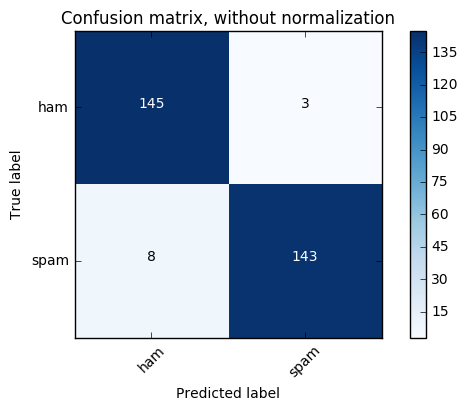

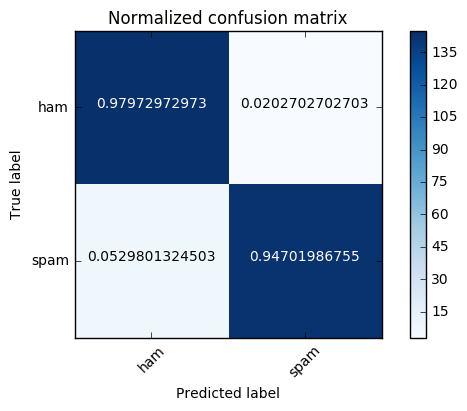

In [55]:
cnf_matrix6 = confusion_matrix(label_test6, label_pred6)
plt.figure()
plot_confusion_matrix(cnf_matrix6, classes=naive_model6.classes_,
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cnf_matrix6, classes=naive_model6.classes_, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [56]:
print(classification_report(label_test6, label_pred6))

             precision    recall  f1-score   support

        ham       0.95      0.98      0.96       148
       spam       0.98      0.95      0.96       151

avg / total       0.96      0.96      0.96       299



In [ ]:
#CountVectorizer с токенезатором без пунктуации выдавал самые лучшие результаты, поэтому я решила сравнить его с TfidfVectorizer
#Очевидно, что результаты стали хуже. Увеличилось количество ошибок распределения ham в spam.

In [58]:
bow7 = TfidfVectorizer(tokenizer=tokenize_without_punct, stop_words='english')
bowed_messages7 = bow7.fit_transform(data['message'])
msg_train7, msg_test7, label_train7, label_test7 = train_test_split(bowed_messages7, data['label'], test_size=0.2)

naive_model7 = MultinomialNB()
naive_model7.fit(msg_train7, label_train7)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [59]:
label_pred7 = naive_model7.predict(msg_test7)

Confusion matrix, without normalization
[[149   6]
 [  5 139]]
Normalized confusion matrix
[[ 0.96129032  0.03870968]
 [ 0.03472222  0.96527778]]


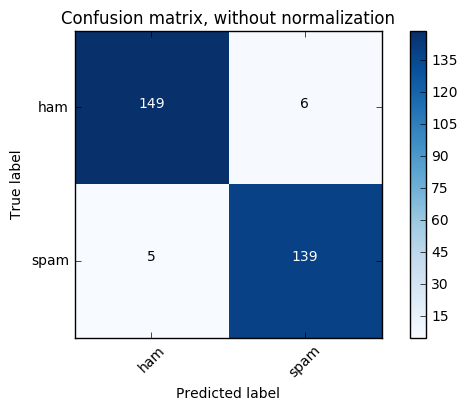

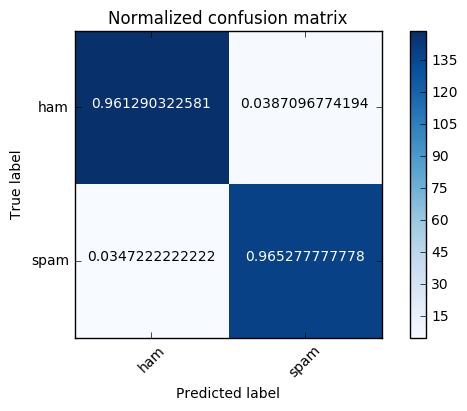

In [60]:
cnf_matrix7 = confusion_matrix(label_test7, label_pred7)
plt.figure()
plot_confusion_matrix(cnf_matrix7, classes=naive_model7.classes_,
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cnf_matrix7, classes=naive_model7.classes_, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [61]:
print(classification_report(label_test7, label_pred7))

             precision    recall  f1-score   support

        ham       0.97      0.96      0.96       155
       spam       0.96      0.97      0.96       144

avg / total       0.96      0.96      0.96       299



In [ ]:
#Используя TfidfVectorizer с токенезатором без пунктуации и удаления стоп слов, мы получили самые лучшие результаты в 
#распределении spam, но немного увеличилось количество ошибок в распределении ham.

In [62]:
#TASK 2
#программа для построения learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

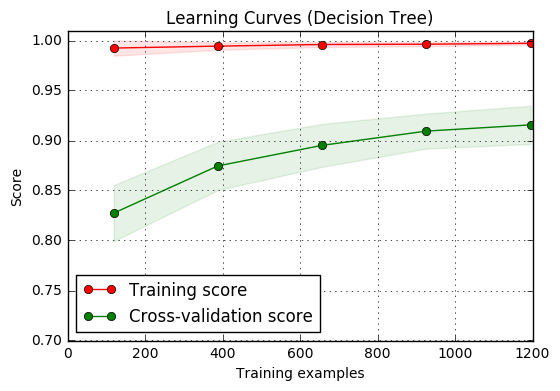

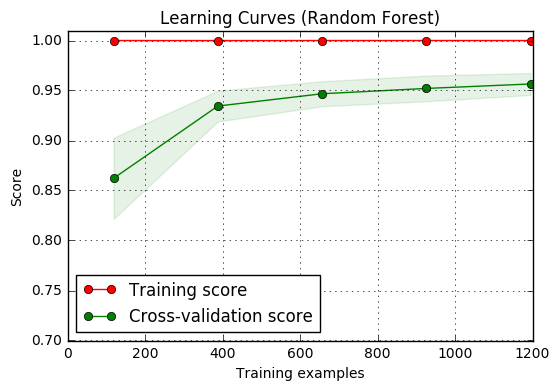

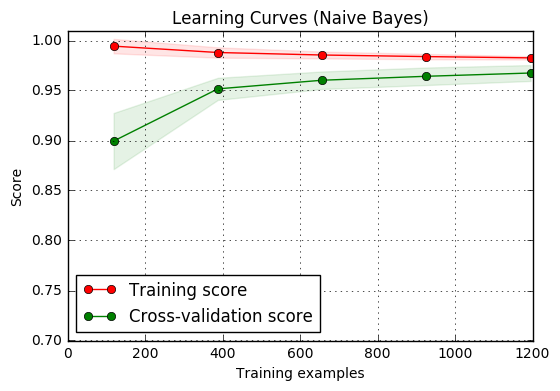

In [64]:
X, y = bowed_messages2, data['label']

title = "Learning Curves (Decision Tree)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = DecisionTreeClassifier(min_samples_split=5)
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (Random Forest)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = RandomForestClassifier(n_estimators = 80)
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (Naive Bayes)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = MultinomialNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

In [66]:
#Decision Tree показал самые плохие результаты.
#У Random Forest самый лучшмй training score, а у NB - самый лучший cross-validation

In [69]:
from sklearn.metrics import roc_curve, auc

In [94]:
#программа для построения ROC-curve
#fpr = dict()
#tpr = dict()
#roc_auc = dict()
#for i in range(n_classes):
    #fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    #roc_auc[i] = auc(fpr[i], tpr[i])
#что-то я до конца не сообразила, как это строится

In [72]:
#Naive Bayes
print(classification_report(label_test2, label_pred2))


             precision    recall  f1-score   support

        ham       0.95      0.99      0.97       144
       spam       0.99      0.95      0.97       155

avg / total       0.97      0.97      0.97       299



In [75]:
#Decision Tree
estimator1 = DecisionTreeClassifier(min_samples_split=5)
estimator1.fit(msg_train2, label_train2)
label_pred_estimator1 = estimator1.predict(msg_test2)
print(classification_report(label_test2, label_pred_estimator1))

             precision    recall  f1-score   support

        ham       0.91      0.93      0.92       144
       spam       0.93      0.92      0.93       155

avg / total       0.92      0.92      0.92       299



In [76]:
#RandomForest
estimator2 = RandomForestClassifier(n_estimators = 100)
estimator2.fit(msg_train2, label_train2)
label_pred_estimator2 = estimator2.predict(msg_test2)
print(classification_report(label_test2, label_pred_estimator2))

             precision    recall  f1-score   support

        ham       0.93      0.99      0.96       144
       spam       0.99      0.93      0.96       155

avg / total       0.96      0.96      0.96       299



In [ ]:
#лучшие результаты - у наивного баиса, худшие - дерево решений

In [78]:
ham = messages.loc[messages['label'] == 'ham']
spam = messages.loc[messages['label'] == 'spam']
ham_new = ham.sample(n=747) #рандомно выбрать 747 строчек из не спама
new_data = ham_new.append(spam)
print(new_data.head())

     label                                            message
757    ham  Cant think of anyone with * spare room off * t...
678    ham  Piggy, r u awake? I bet u're still sleeping. I...
176    ham  Let me know when you've got the money so carlo...
3455   ham  I dont have any of your file in my bag..i was ...
3911   ham  She.s good. She was wondering if you wont say ...


In [90]:
new_data['commas'] = new_data['message'].str.count(',')
new_data.groupby(['label']).agg({'commas': 'mean'})

,commas
label,
ham,0.321285
spam,0.551539


In [84]:
new_data['len'] = new_data['message'].str.len()
new_data.groupby(['label']).agg({'len': 'mean'})

,len
label,
ham,70.417671
spam,138.670683


In [86]:
new_data['exclam'] = new_data['message'].str.count('!')
new_data.groupby(['label']).agg({'exclam': 'mean'})

,exclam
label,
ham,0.141901
spam,0.729585


In [87]:
new_data['num'] = new_data.apply(lambda x: sum(s.isdigit() for s in x['message']), axis=1)
new_data.groupby(['label']).agg({'num': 'mean'})

,num
label,
ham,0.313253
spam,15.812584


In [89]:
new_data['hreg'] = new_data.apply(lambda x: sum(s.isupper() for s in x['message']), axis=1)
new_data.groupby(['label']).agg({'hreg': 'mean'})

,hreg
label,
ham,3.843373
spam,15.469880


In [91]:
features = ['len', 'exclam', 'commas', 'num', 'hreg']
X, y = new_data[features], new_data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [92]:
naive = MultinomialNB()
naive.fit(np.array(X_train), np.array(y_train))
new_predict = naive.predict(X_test)
print(classification_report(y_test, new_predict))

             precision    recall  f1-score   support

        ham       0.86      0.96      0.91       140
       spam       0.96      0.86      0.91       159

avg / total       0.91      0.91      0.91       299



Confusion matrix, without normalization
[[134   6]
 [ 22 137]]
Normalized confusion matrix
[[ 0.95714286  0.04285714]
 [ 0.13836478  0.86163522]]


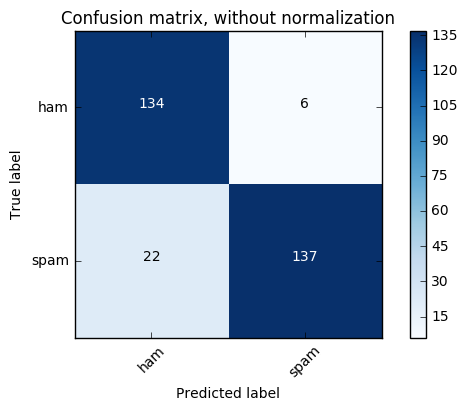

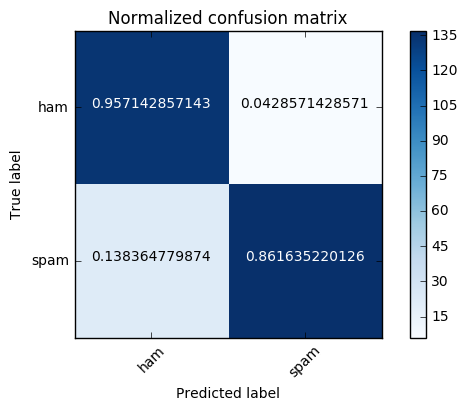

In [93]:
cnf_matrix_own = confusion_matrix(y_test, new_predict)
plt.figure()
plot_confusion_matrix(cnf_matrix_own, classes=naive.classes_,
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cnf_matrix_own, classes=naive.classes_, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
#Самые плохие результаты. Очень много сообщений из класса spam котороые попали в ham